In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import numpy as np

### Menyiapkan Dataset

Dataset yang digunakan adalah `tf_flowers` dari `tensorflow_datasets` (±3.670 gambar, 5 kelas). Dataset dibagi menjadi 70% data latih, 15% data validasi, dan 15% data uji. Gambar disimpan ke folder lokal `flowers/train|validation|test` per kelas agar mudah dipakai oleh `ImageDataGenerator`. Jika gambar sudah ada, proses simpan akan dilewati.

In [2]:
import tensorflow_datasets as tfds
import os
import shutil
import glob
import random
from absl import logging as absl_logging

absl_logging.set_verbosity(absl_logging.ERROR)

TFDS_DIR = os.path.join(os.getcwd(), 'tfds_data')
os.makedirs(TFDS_DIR, exist_ok=True)

base_dir = os.path.join(os.getcwd(), 'flowers')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def has_images(path):
    for root, _, files in os.walk(path):
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
            return True
    return False

def prepare_dirs(class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

def save_images_from_tfds(dataset, directory, class_names):
    for i, (image, label) in enumerate(dataset.as_numpy_iterator()):
        class_name = class_names[label]
        filename = f'image_{i}.jpg'
        filepath = os.path.join(directory, class_name, filename)
        if not os.path.exists(filepath):
            tf.keras.utils.save_img(filepath, image)

class_names = None
used_source = None

already_ready = has_images(train_dir) and has_images(validation_dir) and has_images(test_dir)

if already_ready:
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    used_source = 'existing'
else:
    try:
        (ds_train, ds_validation, ds_test), ds_info = tfds.load(
            'tf_flowers',
            split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
            with_info=True,
            as_supervised=True,
            data_dir=TFDS_DIR,
        )
        class_names = ds_info.features['label'].names
        prepare_dirs(class_names)
        save_images_from_tfds(ds_train, train_dir, class_names)
        save_images_from_tfds(ds_validation, validation_dir, class_names)
        save_images_from_tfds(ds_test, test_dir, class_names)
        used_source = 'tfds'
    except Exception as e:
        print(f"Gagal mengunduh via TFDS: {e.__class__.__name__}: {e}")
        candidates = [
            os.path.join('data', 'flower_photos'),
            os.path.join('local_data', 'flower_photos'),
            os.path.join(os.getcwd(), 'flower_photos'),
        ]
        src_dir = next((d for d in candidates if os.path.isdir(d)), None)
        if src_dir is None:
            raise RuntimeError(
                "Tidak dapat menyiapkan dataset. Aktifkan internet untuk TFDS atau letakkan folder 'flower_photos' di ./data/ atau ./local_data/ atau root repo."
            )
        class_names = sorted([d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))])
        prepare_dirs(class_names)
        random.seed(42)
        for cls in class_names:
            files = [f for f in glob.glob(os.path.join(src_dir, cls, '*')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(files)
            n = len(files)
            n_train = int(0.7 * n)
            n_val = int(0.15 * n)
            train_files = files[:n_train]
            val_files = files[n_train:n_train + n_val]
            test_files = files[n_train + n_val:]
            for f in train_files:
                shutil.copy2(f, os.path.join(train_dir, cls, os.path.basename(f)))
            for f in val_files:
                shutil.copy2(f, os.path.join(validation_dir, cls, os.path.basename(f)))
            for f in test_files:
                shutil.copy2(f, os.path.join(test_dir, cls, os.path.basename(f)))
        used_source = 'local'

print(f"Dataset siap di 'flowers' (train/validation/test). Sumber: {used_source}.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tfds_data/tf_flowers/incomplete.XWAKBY_3.0.1/tf_flowers-train.tfrecord*...:   0%|          …

Dataset tf_flowers downloaded and prepared to /content/tfds_data/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Dataset siap di 'flowers' (train/validation/test). Sumber: tfds.


### Augmentasi Gambar dan Generator Data

Kita akan menggunakan `ImageDataGenerator` untuk melakukan augmentasi gambar pada data latih (seperti rotasi, zoom, flip horizontal) untuk mencegah overfitting. Data validasi tidak akan diaugmentasi. Ukuran gambar akan diubah menjadi 150x150 piksel.

In [3]:
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=applications.mobilenet_v2.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2569 images belonging to 5 classes.
Found 551 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


### Membangun Model Jaringan Saraf Tiruan (CNN)

Model yang akan kita bangun adalah model sekuensial dengan beberapa lapisan konvolusi dan pooling. Arsitektur model ini terdiri dari:
- 3 lapis `Conv2D` dengan fungsi aktivasi `relu` dan `MaxPooling2D`.
- Sebuah lapis `Flatten` untuk mengubah matriks fitur menjadi vektor.
- Sebuah lapis `Dense` dengan 512 neuron dan fungsi aktivasi `relu`.
- Sebuah lapis `Dense` sebagai output dengan 5 neuron (sesuai jumlah kelas) dan fungsi aktivasi `softmax`.

Model akan di-compile dengan `optimizer='adam'`, `loss='categorical_crossentropy'`, dan `metrics=['accuracy']`.

In [6]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 5

# Transfer Learning + tambahan Conv2D & Pooling
base = applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # freeze pretrained weights

model = Sequential([
    base,
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,253 (11.49 MB)

 Trainable params: 755,269 (2.88 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Melatih Model

Kita akan melatih model dengan data generator yang sudah kita siapkan. Kita juga akan menggunakan `EarlyStopping` callback untuk menghentikan training jika akurasi pada validation set tidak meningkat setelah beberapa epoch. Ini akan membantu mencegah overfitting.

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.4883 - loss: 1.4236 - val_accuracy: 0.8327 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 2/50
 1/80 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.6250 - loss: 1.2227

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - accuracy: 0.6250 - loss: 1.2227 - val_accuracy: 0.8401 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7836 - loss: 0.5951 - val_accuracy: 0.8676 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 301ms/step - accuracy: 0.5938 - loss: 0.7576 - val_accuracy: 0.8676 - val_loss: 0.3638 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8248 - loss: 0.4917 - val_accuracy: 0.8787 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.7812 - loss: 0.6920 - val_accuracy: 0.8750 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8509 - loss: 0.4508 - val_accuracy: 0.8860 - val_loss: 0.3474 - learning_rate: 5.0000e-04
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - accuracy: 0.8750 - loss: 0.3576 - val_ac

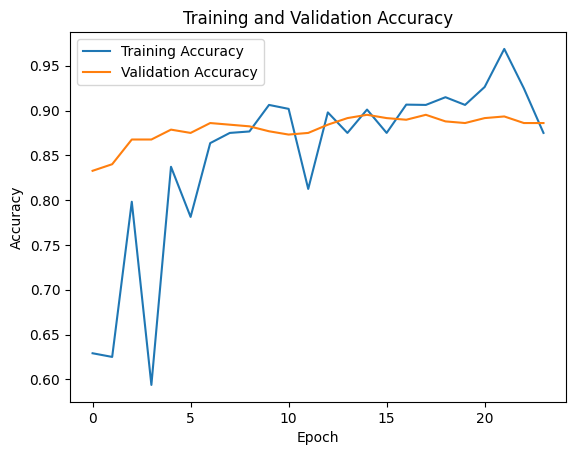

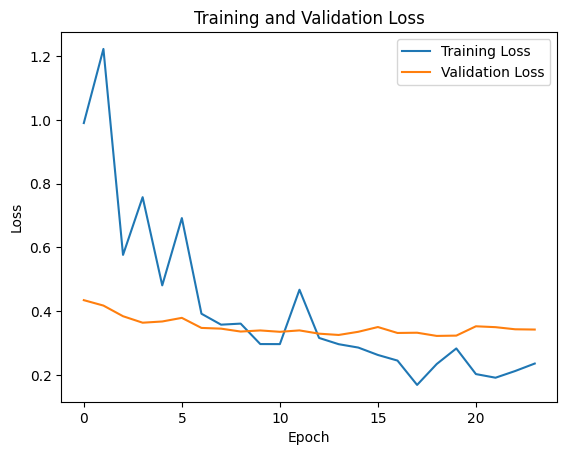

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import warnings

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r"Your `PyDataset` class should call .*super\(\).__init__\(\*\*kwargs\)"
)

os.makedirs('checkpoints', exist_ok=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
ckpt = ModelCheckpoint('checkpoints/best.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, ckpt]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
base.trainable = False
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, ckpt]
)

base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, ckpt]
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9236 - loss: 0.2205 - val_accuracy: 0.8860 - val_loss: 0.3231 - learning_rate: 3.1250e-05
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 0.8750 - loss: 0.2581 - val_accuracy: 0.8879 - val_loss: 0.3247 - learning_rate: 3.1250e-05
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9273 - loss: 0.1941 - val_accuracy: 0.8879 - val_loss: 0.3150 - learning_rate: 3.1250e-05
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 503ms/step - accuracy: 0.9375 - loss: 0.2125 - val_accuracy: 0.8879 - val_loss: 0.3335 - learning_rate: 3.1250e-05
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9271 - loss: 0.2151 - val_accuracy: 0.8934 - val_loss: 0.3229 - learning_rate: 3.1250e-05
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.9688 - loss: 0.0852 - val_accuracy: 0.8897 - val_loss: 0.3432 - learning_rate: 1.5625e-05
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0

17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9192 - loss: 0.2562
Test accuracy: 0.9081, Test loss: 0.2933
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


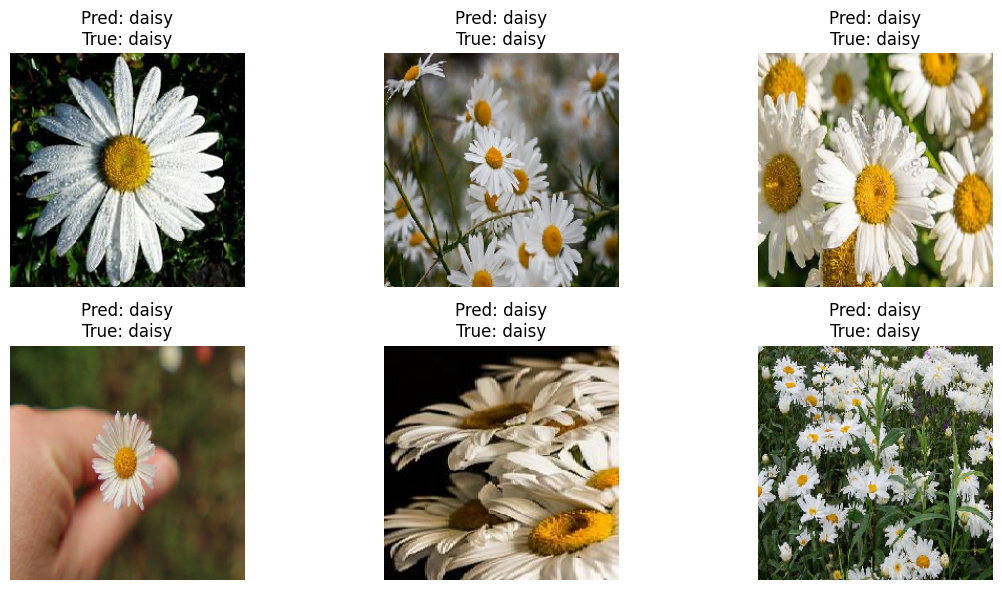

18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


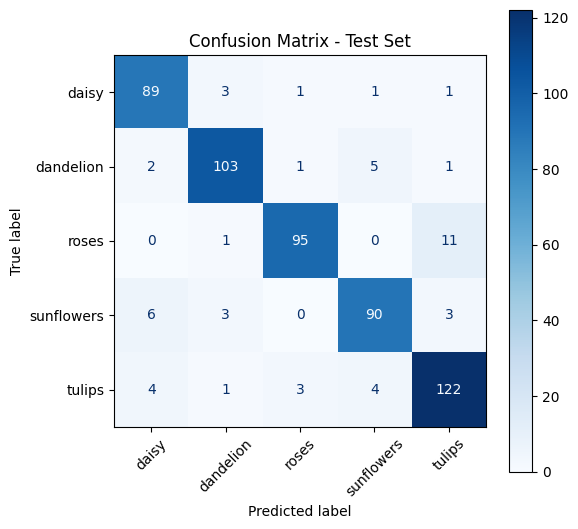

In [13]:
loss, acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {acc:.4f}, Test loss: {loss:.4f}")

batch_images, batch_labels = next(test_generator)
preds = model.predict(batch_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(batch_labels, axis=1)
label_map = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    disp = batch_images[i]
    disp = (disp - disp.min()) / (disp.max() - disp.min() + 1e-8)
    plt.imshow(disp.astype('float32'))
    plt.axis('off')
    plt.title(f"Pred: {label_map[pred_classes[i]]}\nTrue: {label_map[true_classes[i]]}")
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds = model.predict(test_generator)
all_pred_classes = np.argmax(all_preds, axis=1)
cm = confusion_matrix(test_generator.classes, all_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.values())).plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.show()

### Menyimpan Model

Setelah model dilatih, kita akan menyimpannya dalam tiga format yang berbeda:
- **SavedModel**: Format standar TensorFlow.
- **TFLite**: Format yang dioptimalkan untuk perangkat mobile.
- **TFJS**: Format untuk digunakan di lingkungan JavaScript (browser).

In [17]:
import os

os.makedirs("submission", exist_ok=True)

saved_model_dir = "submission/saved_model"
model.export(saved_model_dir)
print(f"SavedModel tersimpan di: {saved_model_dir}")

tflite_dir = "submission/tflite"
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]
tflite_model = converter.convert()

with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

class_names = sorted(train_generator.class_indices.keys())
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    for name in class_names:
        f.write(f"{name}\n")

print(f"Model TFLite tersimpan di: {tflite_dir}")

tfjs_dir = "submission/tfjs_model"
os.makedirs(tfjs_dir, exist_ok=True)

try:
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(model, tfjs_dir)
    print(f"Model TFJS tersimpan di: {tfjs_dir}")
except ImportError:
    print("TensorFlow.js belum terinstall. Jalankan: pip install tensorflowjs")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_474')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140111705075216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705076944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705075408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705076368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705077520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705076752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705077136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705077328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705076560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140111705078480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401

In [18]:
import random

any_class = random.choice(os.listdir(test_dir))
class_dir = os.path.join(test_dir, any_class)
img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
img_path = os.path.join(class_dir, random.choice(img_files))

img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = applications.mobilenet_v2.preprocess_input(x)

interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inp = x.astype(input_details[0]['dtype'])
if tuple(input_details[0]['shape']) != tuple(inp.shape):
    interpreter.resize_tensor_input(input_details[0]['index'], list(inp.shape))
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], inp)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
pred_idx = int(np.argmax(output, axis=1)[0])

label_map = {v: k for k, v in train_generator.class_indices.items()}
print(f"TFLite prediction for {os.path.basename(img_path)} -> {label_map[pred_idx]}")


TFLite prediction for image_51.jpg -> roses


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [23]:
import shutil

shutil.make_archive("/content/submission", 'zip', "/content/submission")

print("Folder submission sudah di-zip jadi: /content/submission.zip")

Folder submission sudah di-zip jadi: /content/submission.zip


In [22]:
from google.colab import files
files.download("/content/submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>